In [33]:
import torch
import torch.nn as nn
from torchvision.utils import save_image, make_grid

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

In [14]:
dataset_path = '/dataset'

cuda = torch.cuda.is_available()
DEVICE = torch.device("cuda" if cuda else "cpu")

batch_size = 100

x_dim  = 784
hidden_dim = 400
latent_dim = 200

lr = 1e-3

epochs = 30

In [5]:
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader


mnist_transform = transforms.Compose([
        transforms.ToTensor(),
])

kwargs = {'num_workers': 1, 'pin_memory': True} 

train_dataset = MNIST(dataset_path, transform=mnist_transform, train=True, download=True)
test_dataset  = MNIST(dataset_path, transform=mnist_transform, train=False, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader  = DataLoader(dataset=test_dataset,  batch_size=batch_size, shuffle=False, **kwargs)


Extracting /dataset\MNIST\raw\train-images-idx3-ubyte.gz to /dataset\MNIST\raw




Extracting /dataset\MNIST\raw\train-labels-idx1-ubyte.gz to /dataset\MNIST\raw




Extracting /dataset\MNIST\raw\t10k-images-idx3-ubyte.gz to /dataset\MNIST\raw




Extracting /dataset\MNIST\raw\t10k-labels-idx1-ubyte.gz to /dataset\MNIST\raw

Processing...


C:\ProgramData\Anaconda3\lib\site-packages\torchvision\datasets\mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!


In [8]:
# Encoder
class Encoder(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()

        self.FC_input = nn.Linear(input_dim, hidden_dim)
        self.FC_input2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_mean  = nn.Linear(hidden_dim, latent_dim)
        self.FC_var   = nn.Linear (hidden_dim, latent_dim)
        
        # Set ReLU with alpha = 0.3
        self.LeakyReLU = nn.LeakyReLU(0.3)
        
        self.training = True
        
    def forward(self, x):
        h_       = self.LeakyReLU(self.FC_input(x))
        h_       = self.LeakyReLU(self.FC_input2(h_))
        mean     = self.FC_mean(h_)
        log_var  = self.FC_var(h_)
        # returns the mean and log_variance which will be later used to generate samples
        return mean, log_var

In [9]:
# Decoder
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.FC_hidden = nn.Linear(latent_dim, hidden_dim)
        self.FC_hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_output = nn.Linear(hidden_dim, output_dim)
        
        # Set ReLU with alpha = 0.3
        self.LeakyReLU = nn.LeakyReLU(0.3)
        
    def forward(self, x):
        h     = self.LeakyReLU(self.FC_hidden(x))
        h     = self.LeakyReLU(self.FC_hidden2(h))
        
        x_hat = torch.sigmoid(self.FC_output(h))
        return x_hat

In [10]:
class Model(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(Model, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder
 
    # reparameterization trick in order to backpropagate through a random node
    def reparameterization(self, mean, std):
        # sampling epsilon 
        epsilon = torch.randn_like(std).to(DEVICE)      
        z = mean + std*epsilon                          
        return z
        
                
    def forward(self, x):
        mean, log_var = self.Encoder(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var)) 
        x_hat = self.Decoder(z)
        
        return x_hat, mean, log_var

In [15]:
encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim, hidden_dim = hidden_dim, output_dim = x_dim)

model = Model(Encoder=encoder, Decoder=decoder).to(DEVICE)

In [18]:
# Loss Function
'''
1. Reproduction Loss: With Binary Cross Entropy we penalize the network for creating outputs different from the input.

2. Kullback-Liebler Divergence: Measures how much one probability distribution differs from another probability distribution. 
                                Minimizing the KL divergence here means optimizing the probability distribution parameters 
                                (mean and std. deviation) to closely resemble that of the target distribution.
'''
from torch.optim import Adam

BCE_loss = nn.BCELoss()

def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD      = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD


optimizer = Adam(model.parameters(), lr=lr)

In [19]:
print("Training VAE...")
model.train()

for epoch in tqdm(range(epochs)):
    overall_loss = 0
    for batch_idx, (x, _) in enumerate(train_loader):
        x = x.view(batch_size, x_dim)
        x = x.to(DEVICE)

        optimizer.zero_grad()

        x_hat, mean, log_var = model(x)
        loss = loss_function(x, x_hat, mean, log_var)
        
        overall_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        
    print("\nEpoch", epoch + 1, "complete.", "\tAverage Loss: ", overall_loss / (batch_idx*batch_size))
    
print("Finished.")


  0%|                                                                                           | 0/30 [00:00<?, ?it/s]

Training VAE...


  3%|██▊                                                                                | 1/30 [00:15<07:39, 15.84s/it]


Epoch 1 complete. 	Average Loss:  172.51361116183222


  7%|█████▌                                                                             | 2/30 [00:31<07:18, 15.65s/it]


Epoch 2 complete. 	Average Loss:  128.20548146650668


 10%|████████▎                                                                          | 3/30 [00:46<07:01, 15.63s/it]


Epoch 3 complete. 	Average Loss:  116.25850636477462


 13%|███████████                                                                        | 4/30 [03:25<25:26, 58.73s/it]


Epoch 4 complete. 	Average Loss:  112.54551020907242


 17%|█████████████▊                                                                     | 5/30 [03:40<18:58, 45.54s/it]


Epoch 5 complete. 	Average Loss:  110.40741990231115


 20%|████████████████▌                                                                  | 6/30 [03:56<14:38, 36.60s/it]


Epoch 6 complete. 	Average Loss:  108.74440020476837


 23%|███████████████████▎                                                               | 7/30 [06:47<29:30, 76.98s/it]


Epoch 7 complete. 	Average Loss:  107.43113894250834


 27%|██████████████████████▏                                                            | 8/30 [07:01<21:18, 58.13s/it]


Epoch 8 complete. 	Average Loss:  106.53855667649206


 30%|████████████████████████▉                                                          | 9/30 [07:16<15:46, 45.09s/it]


Epoch 9 complete. 	Average Loss:  105.77924822621036


 33%|███████████████████████████▎                                                      | 10/30 [07:30<11:56, 35.80s/it]


Epoch 10 complete. 	Average Loss:  105.09750311391382


 37%|██████████████████████████████                                                    | 11/30 [07:45<09:20, 29.50s/it]


Epoch 11 complete. 	Average Loss:  104.54893717719636


 40%|████████████████████████████████▊                                                 | 12/30 [07:59<07:29, 24.99s/it]


Epoch 12 complete. 	Average Loss:  104.05256325646911


 43%|███████████████████████████████████▌                                              | 13/30 [08:14<06:09, 21.75s/it]


Epoch 13 complete. 	Average Loss:  103.71385494378652


 47%|██████████████████████████████████████▎                                           | 14/30 [08:28<05:13, 19.60s/it]


Epoch 14 complete. 	Average Loss:  103.3238290705864


 50%|█████████████████████████████████████████                                         | 15/30 [08:42<04:29, 17.95s/it]


Epoch 15 complete. 	Average Loss:  103.02185401776399


 53%|███████████████████████████████████████████▋                                      | 16/30 [08:57<03:58, 17.05s/it]


Epoch 16 complete. 	Average Loss:  102.75529432191674


 57%|██████████████████████████████████████████████▍                                   | 17/30 [09:11<03:30, 16.19s/it]


Epoch 17 complete. 	Average Loss:  102.53915035801857


 60%|█████████████████████████████████████████████████▏                                | 18/30 [09:26<03:08, 15.67s/it]


Epoch 18 complete. 	Average Loss:  102.26182048205342


 63%|███████████████████████████████████████████████████▉                              | 19/30 [09:40<02:47, 15.25s/it]


Epoch 19 complete. 	Average Loss:  102.13363100284327


 67%|██████████████████████████████████████████████████████▋                           | 20/30 [09:55<02:30, 15.03s/it]


Epoch 20 complete. 	Average Loss:  101.94338730240506


 70%|█████████████████████████████████████████████████████████▍                        | 21/30 [10:09<02:13, 14.88s/it]


Epoch 21 complete. 	Average Loss:  101.78206180222246


 73%|████████████████████████████████████████████████████████████▏                     | 22/30 [10:23<01:57, 14.70s/it]


Epoch 22 complete. 	Average Loss:  101.68497370291632


 77%|██████████████████████████████████████████████████████████████▊                   | 23/30 [10:38<01:41, 14.55s/it]


Epoch 23 complete. 	Average Loss:  101.45130880569178


 80%|█████████████████████████████████████████████████████████████████▌                | 24/30 [10:52<01:26, 14.48s/it]


Epoch 24 complete. 	Average Loss:  101.36096117226627


 83%|████████████████████████████████████████████████████████████████████▎             | 25/30 [11:06<01:12, 14.40s/it]


Epoch 25 complete. 	Average Loss:  101.21046058208994


 87%|███████████████████████████████████████████████████████████████████████           | 26/30 [11:21<00:57, 14.44s/it]


Epoch 26 complete. 	Average Loss:  101.12847533975898


 90%|█████████████████████████████████████████████████████████████████████████▊        | 27/30 [11:35<00:42, 14.29s/it]


Epoch 27 complete. 	Average Loss:  100.99155081059578


 93%|████████████████████████████████████████████████████████████████████████████▌     | 28/30 [11:49<00:28, 14.35s/it]


Epoch 28 complete. 	Average Loss:  100.89046954885747


 97%|███████████████████████████████████████████████████████████████████████████████▎  | 29/30 [12:03<00:14, 14.21s/it]


Epoch 29 complete. 	Average Loss:  100.81727945012521


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [12:18<00:00, 24.60s/it]


Epoch 30 complete. 	Average Loss:  100.68334010460141
Finished.


In [32]:
model.eval()

with torch.no_grad():
    for batch_idx, (x, _) in enumerate(test_loader):
        x = x.view(batch_size, x_dim)
        x = x.to(DEVICE)     
        x_hat, _, _ = model(x)
        break

In [34]:
def show_image(x, idx):
    x = x.view(batch_size, 28, 28)
    fig = plt.figure()
    plt.imshow(x[idx].cpu().detach().numpy())

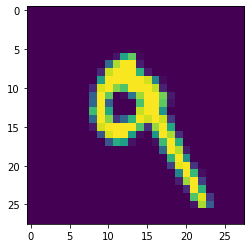

In [35]:
show_image(x, idx=7)

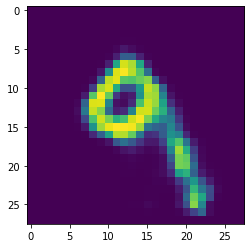

In [36]:
show_image(x_hat, idx=7)